# Typical El Nino and La Nina Rainfall Patterns (DJF)
1. Calculate Nino3.4 index
2. Calculate seasonal precip for DJF
3. Define El Nino year and La Nina year from nino3.4 anomalies
4. Take average of all El Nino years, La Nina years, and neutral years from precip dataset
5. Plot respective rainfall patterns

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read in datasets
ersst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.nc')
awap_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/rr_monthly_0.25.1900-2015.nc')

In [3]:
#Select varaibles
sst = ersst_ds.sst
precip = awap_ds.rr

In [4]:
#Calculate ersst Nino3.4 index (Not normalised, just anom)
nino_region = sst.sel(lat=slice(5,-5), lon=slice(190,240))
nino_clim = nino_region.sel(time=slice('1950-01', '1979-12')).mean(dim='time')
nino_anom = (nino_region - nino_clim).mean(dim='lat').mean(dim='lon')

In [5]:
#Make datasets the same size
nino34 = nino_anom.sel(time=slice('1900-01', '2015-12'))

In [6]:
seasonyear = (precip.time.dt.year + (precip.time.dt.month//12))
precip.coords['seasonyear'] = seasonyear
seasonyear2 = (nino34.time.dt.year + (nino34.time.dt.month//12))
nino34.coords['seasonyear'] = seasonyear2

In [7]:
def seasonal_mean(data):
    return data.groupby('time.season').mean()

In [8]:
yearly_seasonal_precip = precip.groupby('seasonyear').apply(seasonal_mean)
yearly_seasonal_nino34 = nino34.groupby('seasonyear').apply(seasonal_mean)

In [9]:
#Find el nino and la nina years using DJF seasonal average
nino34_djf = yearly_seasonal_nino34.sel(season='DJF')

elnino = nino34_djf.where(nino34_djf > 0.5, drop = True)
lanina = nino34_djf.where(nino34_djf < -0.5, drop = True)
neutral = nino34_djf.where((nino34_djf > -0.5) & (nino34_djf < 0.5), drop = True)

#Calculate respective rainfall patterns for DJF
precip_djf = yearly_seasonal_precip.sel(season='DJF')

nino_pattern = precip_djf.where(precip_djf.seasonyear.isin(elnino.seasonyear.values), drop = True).mean(dim='seasonyear')
nina_pattern = precip_djf.where(precip_djf.seasonyear.isin(lanina.seasonyear.values), drop = True).mean(dim='seasonyear')
neutral_pattern = precip_djf.where(precip_djf.seasonyear.isin(neutral.seasonyear.values), drop = True).mean(dim='seasonyear')

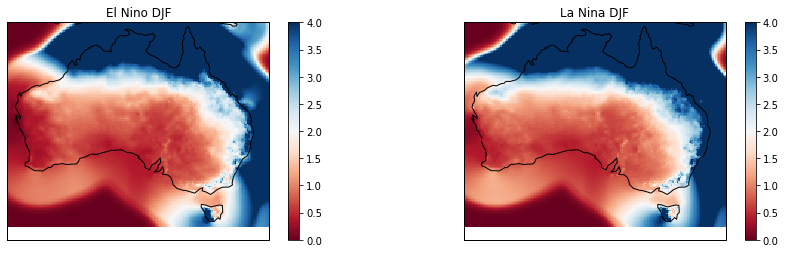

In [14]:
#Plot patterns
f = plt.figure()

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nino_pattern.lon, nino_pattern.lat, nino_pattern, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('El Nino DJF')

ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nina_pattern.lon, nina_pattern.lat, nina_pattern, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('La Nina DJF')

f.set_figwidth(15)

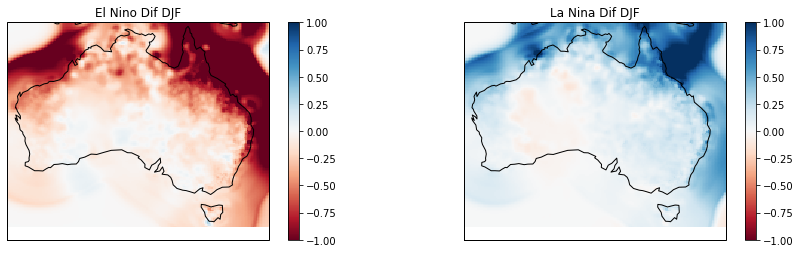

In [17]:
#Calculate difference of el nino year and average of all years
mean = precip_djf.mean(dim='seasonyear')

nino_dif = nino_pattern - mean
nina_dif = nina_pattern - mean

f = plt.figure()

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nino_dif.lon, nino_dif.lat, nino_dif, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(-1, 1)
plt.colorbar(im, ax=ax)
ax.set_title('El Nino Dif DJF')

ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nina_dif.lon, nina_dif.lat, nina_dif, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(-1, 1)
plt.colorbar(im, ax=ax)
ax.set_title('La Nina Dif DJF')

f.set_figwidth(15)

### Repeat above but with different nino3.4 thresholds to try and get a stronger signal. Aim for approx 10 el nino and 10 La Nina events. 

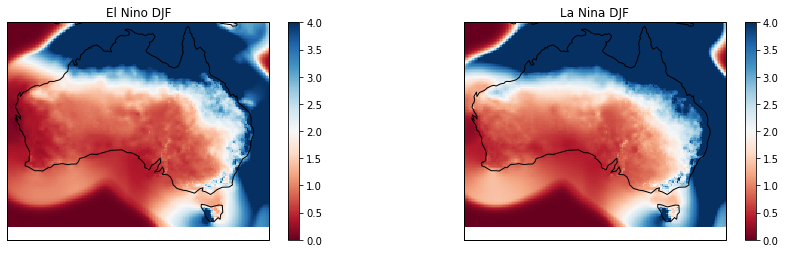

In [18]:
elnino2 = nino34_djf.where(nino34_djf > 1, drop = True)
lanina2 = nino34_djf.where(nino34_djf < -1, drop = True)

nino_pattern2 = precip_djf.where(precip_djf.seasonyear.isin(elnino2.seasonyear.values), drop = True).mean(dim='seasonyear')
nina_pattern2 = precip_djf.where(precip_djf.seasonyear.isin(lanina2.seasonyear.values), drop = True).mean(dim='seasonyear')

f = plt.figure()

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nino_pattern2.lon, nino_pattern2.lat, nino_pattern2, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('El Nino DJF')

ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nina_pattern2.lon, nina_pattern2.lat, nina_pattern2, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('La Nina DJF')

f.set_figwidth(15)

### Try only using events from post 1950

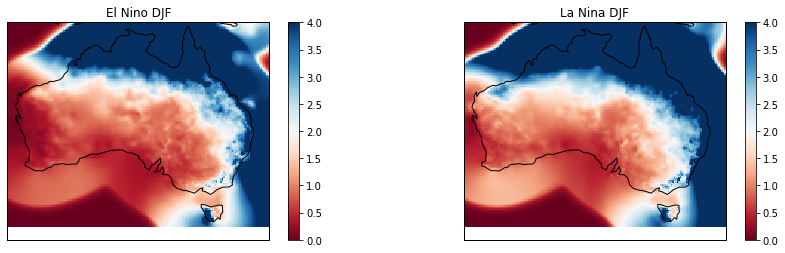

In [19]:
nino34_djf_post_1950 = yearly_seasonal_nino34.sel(season='DJF').sel(seasonyear=slice(1950, 2016))
precip_djf_post_1950 = yearly_seasonal_precip.sel(season='DJF').sel(seasonyear=slice(1950, 2016))

elnino3 = nino34_djf_post_1950.where(nino34_djf > 1, drop = True)
lanina3 = nino34_djf_post_1950.where(nino34_djf < -1, drop = True)

nino_pattern3 = precip_djf_post_1950.where(precip_djf_post_1950.seasonyear.isin(elnino3.seasonyear.values), drop = True).mean(dim='seasonyear')
nina_pattern3 = precip_djf_post_1950.where(precip_djf_post_1950.seasonyear.isin(lanina3.seasonyear.values), drop = True).mean(dim='seasonyear')

f = plt.figure()

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nino_pattern3.lon, nino_pattern3.lat, nino_pattern3, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('El Nino DJF')

ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nina_pattern3.lon, nina_pattern3.lat, nina_pattern3, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('La Nina DJF')

f.set_figwidth(15)

### Repeat for SON

In [21]:
#Find el nino and la nina years using DJF seasonal average
nino34_son = yearly_seasonal_nino34.sel(season='SON')

elnino = nino34_son.where(nino34_son > 0.5, drop = True)
lanina = nino34_son.where(nino34_son < -0.5, drop = True)

#Calculate respective rainfall patterns for DJF
precip_son = yearly_seasonal_precip.sel(season='SON')

nino_pattern = precip_son.where(precip_son.seasonyear.isin(elnino.seasonyear.values), drop = True).mean(dim='seasonyear')
nina_pattern = precip_son.where(precip_son.seasonyear.isin(lanina.seasonyear.values), drop = True).mean(dim='seasonyear')

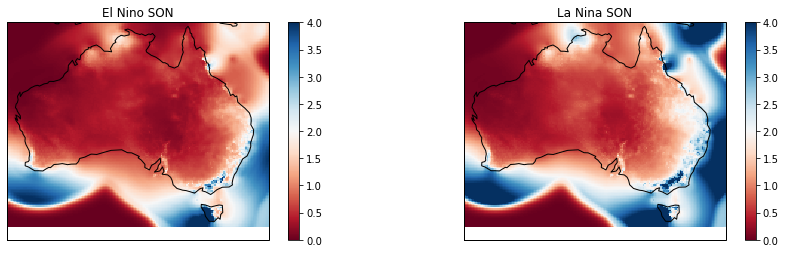

In [22]:
#Plot patterns
f = plt.figure()

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nino_pattern.lon, nino_pattern.lat, nino_pattern, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('El Nino SON')

ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent([112, 156.2, -44.5, -10])
im = ax.pcolormesh(nina_pattern.lon, nina_pattern.lat, nina_pattern, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
im.set_clim(0, 4)
plt.colorbar(im, ax=ax)
ax.set_title('La Nina SON')

f.set_figwidth(15)